In [1]:
import pandas as pd
df=pd.read_csv('job.csv',encoding='latin-1')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company                     3197 non-null   object
 1   Job Title                   3197 non-null   object
 2   Location                    3197 non-null   object
 3   Job Type                    3197 non-null   object
 4   Experience level            2962 non-null   object
 5   Salary                      3009 non-null   object
 6   Requirment of the company   3198 non-null   object
 7   Facilities                  3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB


In [3]:
df.duplicated().sum()

202

In [4]:
df.isnull().sum()

Company                         1
Job Title                       1
Location                        1
Job Type                        1
Experience level              236
Salary                        189
Requirment of the company       0
Facilities                      0
dtype: int64

In [5]:
df.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."


In [6]:
df=df.drop_duplicates()

In [7]:
df['Salary'] = df['Salary'].str.replace('K', '000')
df['Salary'] = df['Salary'].str.replace(r'\D', '', regex=True)

In [8]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

In [9]:
# Define a function to clean individual facilities by removing unwanted entries
def clean_facility(facility):
    return facility.replace(',,,,,', '').replace(',,,,', '').replace(',,,', '').replace(',,', ',')
df['Facilities'] = df['Facilities'].apply(clean_facility)


In [10]:
def clean_facilities(row):
    facilities = row['Facilities']
    if not any(c.isalpha() for c in facilities):  # Check if 'Facilities' has no alphabetic characters
        facilities = f"{row['Company']} - {row['Location']} - {row['Job Title']}"
    return facilities

df['Facilities'] = df.apply(clean_facilities, axis=1)

In [11]:
df[df['Job Type'] == 'Internship']['Salary'].isnull().all()

True

In [12]:
df.loc[df['Job Type'] == 'Internship', 'Salary'] = 0

In [13]:
df.dropna(subset=['Experience level', 'Salary'], how='all',inplace=True)

In [14]:
df['Experience level'].unique()

array(['Entry-level', nan, 'Mid-level', 'Senior-level', 'Executive-level'],
      dtype=object)

In [15]:
df['Experience level'].fillna('Unspecified', inplace=True)

In [16]:
median_salary_by_experience_level = df.groupby('Experience level')['Salary'].median()
df['Salary'].fillna(df['Experience level'].map(median_salary_by_experience_level), inplace=True)


In [19]:
from geotext import GeoText
def extract_city_country(location):
    places = GeoText(location)
    cities = list(places.cities)
    countries = list(places.countries)
    city = cities[0] if cities else None
    country = countries[0] if countries else None
    return city, country
df['City'], df['Country'] = zip(*df['Location'].apply(extract_city_country))


In [24]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def get_country_from_city(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return location.address.split(",")[-1].strip()
    except:
        pass
    return None
df['Country'] = df.apply(lambda row: get_country_from_city(row['City']) if pd.isnull(row['Country']) and pd.notnull(row['City']) else row['Country'], axis=1)

In [25]:
from langdetect import detect
from mtranslate import translate

# Function to translate country name to English
def translate_to_english(country_name):
    try:
        # Detect the language of the country name
        lang = detect(country_name)
        
        # If the language is not English, translate to English
        if lang != 'en':
            translated_name = translate(country_name, 'en', lang)
            return translated_name
        else:
            return country_name
    except:
        return country_name
df['Country'] = df['Country'].apply(translate_to_english)


In [22]:
# import pycountry
# short_to_full_country_mapping = {country.alpha_2: country.name for country in pycountry.countries}
# def extract_country(location, country):
#     if pd.isnull(country): 
#         if "remote" in location.lower():
#             return "Remote"
#         for i in range(len(location) - 1):
#             if location[i].isupper() and location[i + 1].isupper():
#                 country_code = location[i:i+2]
#                 # Check if country code is a short name and replace with full name
#                 country = short_to_full_country_mapping.get(country_code, country)
#                 return country
#     return country
# df['Country'] = df.apply(lambda row: extract_country(row['Location'], row['Country']), axis=1)

In [26]:
df['Country'] = df['Country'].fillna('Unknown')

In [ ]:
# import re
# from collections import Counter


# # Join all the job titles into a single string
# all_job_titles = ' '.join(df['Job Title'])

# # Tokenize the text into words (using regex to handle word boundaries)
# tokens = re.findall(r'\b\w+\b', all_job_titles)

# # Count the occurrences of each word
# word_counts = Counter(tokens)

# # Get the most common words and their frequencies
# most_common_words = word_counts.most_common()

# # Display the most common words and their frequencies
# print(most_common_words)


In [27]:
domain_mapping = {
    'Big': 'Big Data',
    'Data Analyst': 'Data Analyst',
    'Analytics': 'Data Analyst',
    'Analyst': 'Data Analyst',
    'Scientist': 'Data Scientist',
    'Machine Learning': 'Machine Learning',
    'ML': 'Machine Learning',
    'Machine learning': 'Machine Learning',
    'Business': 'Business Intelligence',
    'BI': 'Business Intelligence',
    'Data Management': 'Data Management',
    'Data Architect': 'Data Architect',
    'Engineer Data': 'Engineer Data',
    'data': 'Data Scientist',
    'AI': 'Artificial intelligence',
    'Artificial': 'Artificial intelligence',
    'Software': 'Software Engineer',
    'Computer': 'Computer Engineer',
    'Software Engineer': 'Software Engineer',
    'Web Developer': 'Web Developer',
    'Database Administrator': 'Database Administrator',
    'IT Support Specialist': 'IT Support Specialist',
    'Développeur': 'IT Developer',
    'Robotics': 'Robotics Engineer',
    'Research Engineer': 'Research Engineer',
    'Deep Learning Engineer': 'Deep Learning Engineer',
    'Engineering Manager': 'Engineering Manager',
    'Product Manager': 'Product Manager',
    'Research Analyst': 'Research Analyst',
    'ETL': 'ETL Developer',
    'DevOps': 'DevOps Engineer',
    'Deep Learning': 'Deep Learning',
    'Frontend': 'Frontend Developer',
    'Developer': 'IT Developer',
    'Development': 'IT Developer',
}
def assign_job_domain(job_title):
    for keyword, domain in domain_mapping.items():
        if keyword.lower() in job_title.lower():
            return domain
    return 'IT Developer'

df['Job Domain'] = df['Job Title'].apply(assign_job_domain)



In [28]:
df[['Job Title', 'Job Domain']].sample(n=5)

,Job Title,Job Domain
1501,Staff Data Engineer,Data Scientist
2572,Head of Data & Analytics,Data Analyst
839,Stage Ingénieur Machine Learning (F/H),Machine Learning
1808,Data Scientist Analyst,Data Analyst
2026,Data Analyst,Data Analyst


In [30]:
import plotly.express as px
job_domain_counts = df['Job Domain'].value_counts()
fig = px.bar(
    job_domain_counts,
    x=job_domain_counts.index,
    y=job_domain_counts.values,
    color=job_domain_counts.index,
    labels={'x': 'Job Domain', 'y': 'Number of Job Listings'},
    title='Trends Job Domain'
)
fig.show()


In [ ]:
import plotly.express as px
df_avg_salary = df.groupby('Job Domain')['Salary'].mean().reset_index()

df_top_10 = df_avg_salary.nlargest(10, 'Salary')
fig = px.bar(df_top_10, x='Job Domain', y='Salary', color='Salary',
             labels={'Salary': 'Average Salary (USD)'}, title='Top 10 Job Domains by Average Salary')
fig.update_layout(
    xaxis_title=None,
    yaxis_title='Average Salary (USD)',
    coloraxis_showscale=False,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template='plotly_white'
)
fig.show()


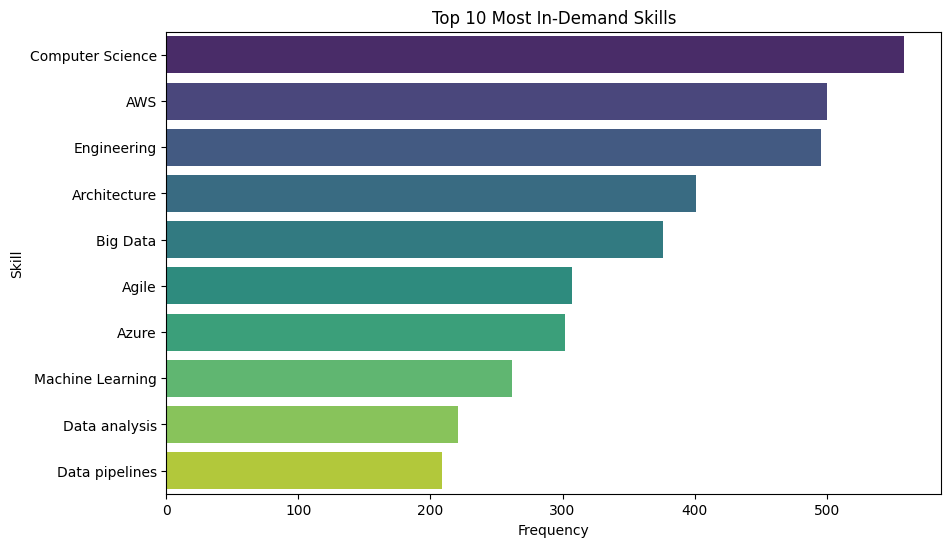

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']
# filtered_df = df[df['Job Domain'].isin(domains)]

# filtered_df = filtered_df.dropna(subset=['Requirment of the company '])
# filtered_df = filtered_df[filtered_df['Requirment of the company '] != '']

# skills_count = filtered_df['Requirment of the company '].str.split(',').explode().str.strip().value_counts()
# skills_count = skills_count[skills_count.index != '']

# top_skills = 10
# top_skills_df = skills_count.nlargest(top_skills)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_skills_df.values, y=top_skills_df.index, palette='viridis')
# plt.xlabel('Frequency')
# plt.ylabel('Skill')
# plt.title('Top 10 Most In-Demand Skills')
# plt.show()


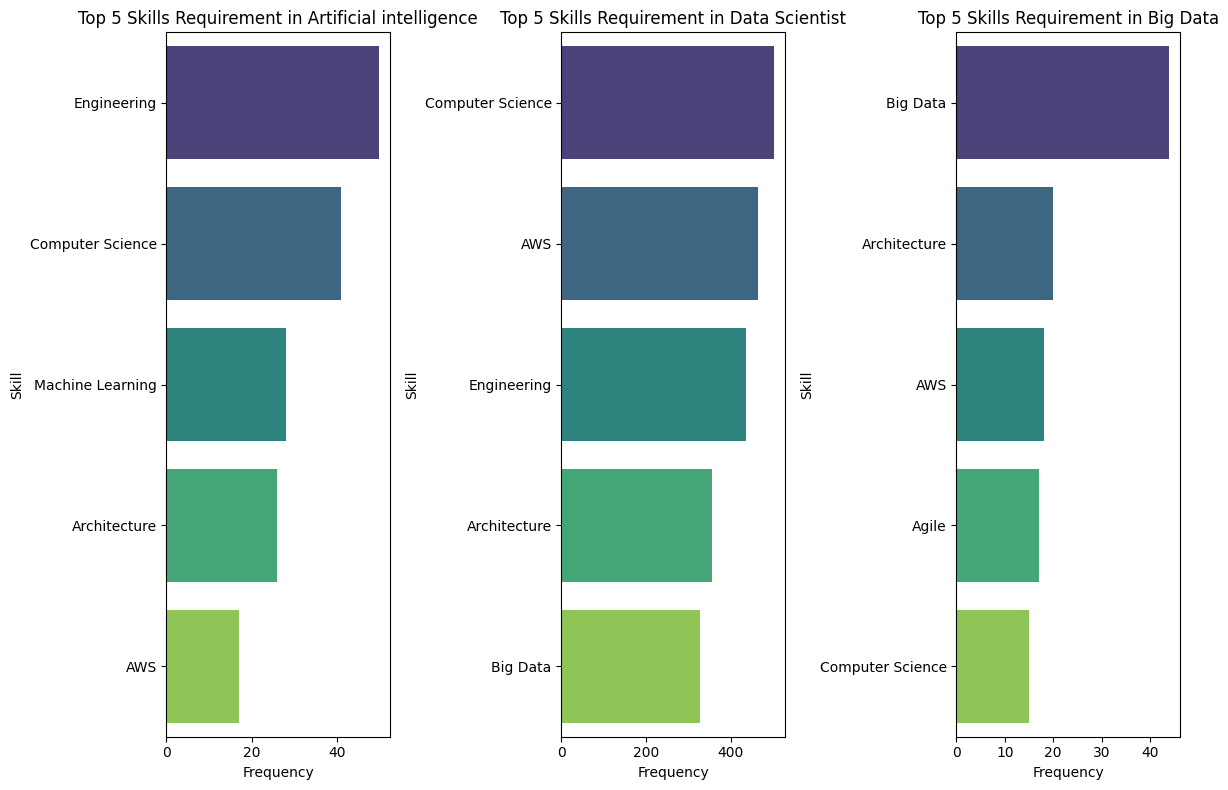

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']

filtered_df = df[df['Job Domain'].isin(domains)]

# Drop rows with null or empty values in 'Requirment of the company' column
filtered_df = filtered_df.dropna(subset=['Requirment of the company '])
filtered_df = filtered_df[filtered_df['Requirment of the company '] != '']

domain_dfs = {}
for domain in domains:
    domain_dfs[domain] = filtered_df[filtered_df['Job Domain'] == domain]

# Find the top 5 skills requirement for each domain
top_skills_by_domain = {}
for domain, domain_df in domain_dfs.items():
    skills_count = domain_df['Requirment of the company '].str.split(',').explode().str.strip().value_counts()
    # Remove any empty skill values
    skills_count = skills_count[skills_count.index != '']
    top_skills_by_domain[domain] = skills_count.nlargest(5)

# Create horizontal bar charts for each domain using Seaborn
plt.figure(figsize=(12, 8))
for i, (domain, top_skills_df) in enumerate(top_skills_by_domain.items(), 1):
    plt.subplot(1, 3, i)
    sns.barplot(x=top_skills_df.values, y=top_skills_df.index, palette='viridis')
    plt.xlabel('Frequency')
    plt.ylabel('Skill')
    plt.title(f'Top 5 Skills Requirement in {domain}')

plt.tight_layout()
plt.show()


In [ ]:
# import plotly.express as px

# # Filter the data for AI, DS, and Big Data domains
# domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']
# filtered_df = df[df['Job Domain'].isin(domains)]

# # Locations comparison using Plotly Express choropleth map
# fig = px.choropleth(filtered_df, 
#                     locations='Country', 
#                     locationmode='country names',
#                     color='Job Domain',
#                     title='Comparison of Job Locations in AI, DS, and Big Data',
#                     labels={'Country': 'Country', 'Job Domain': 'Job Domain'},
#                     scope='world',  # Set the scope to 'world' for a global map
#                     color_discrete_map={
#                         'Artificial intelligence': 'blue',
#                         'Data Scientist': 'green',
#                         'Big Data': 'orange'
#                     }
#                    )
# fig.update_layout(autosize=True, margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
# fig.show()


In [ ]:
import plotly.express as px

domain_counts_by_country = df.groupby(['Country', 'Job Domain']).size().reset_index(name='Count')

most_common_domain_by_country = domain_counts_by_country.groupby('Country', as_index=False)['Job Domain'].agg(lambda x: x.value_counts().idxmax())
fig = px.choropleth(
    most_common_domain_by_country,
    locations='Country',
    locationmode='country names',
    color='Job Domain',
    labels={'Country': 'Country', 'Job Domain': 'Job Domain'},
    scope='world',
    color_discrete_sequence=px.colors.qualitative.Dark24,
    title='Most Common Job Domain in Each Country'
)
fig.update_layout(autosize=True, margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
fig.show()


In [37]:
df['Experience level'].unique()

array(['Entry-level', 'Unspecified', 'Mid-level', 'Senior-level',
       'Executive-level'], dtype=object)

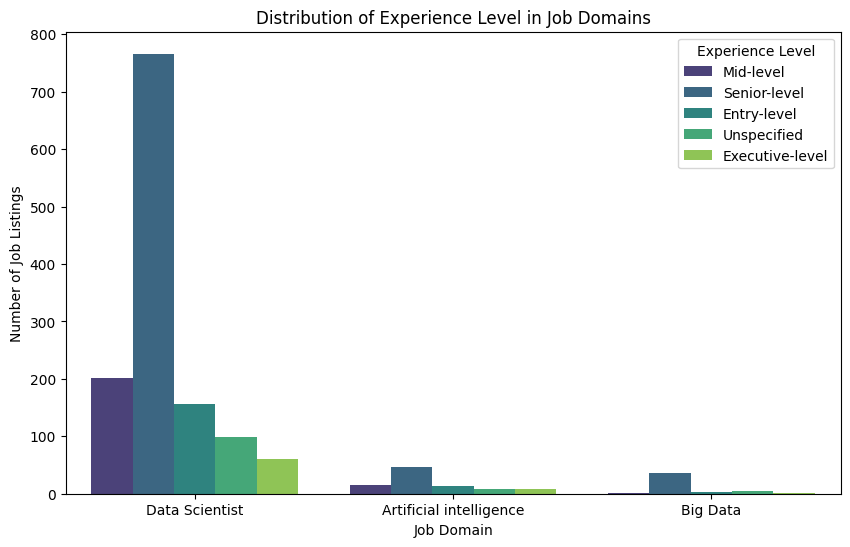

In [45]:
domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']
filtered_df = df[df['Job Domain'].isin(domains)]
plt.figure(figsize=(10, 6))
sns.countplot(x='Job Domain', hue='Experience level', data=filtered_df, palette='viridis')
plt.xlabel('Job Domain')
plt.ylabel('Number of Job Listings')
plt.title('Distribution of Experience Level in Job Domains')
plt.legend(title='Experience Level')
plt.show()


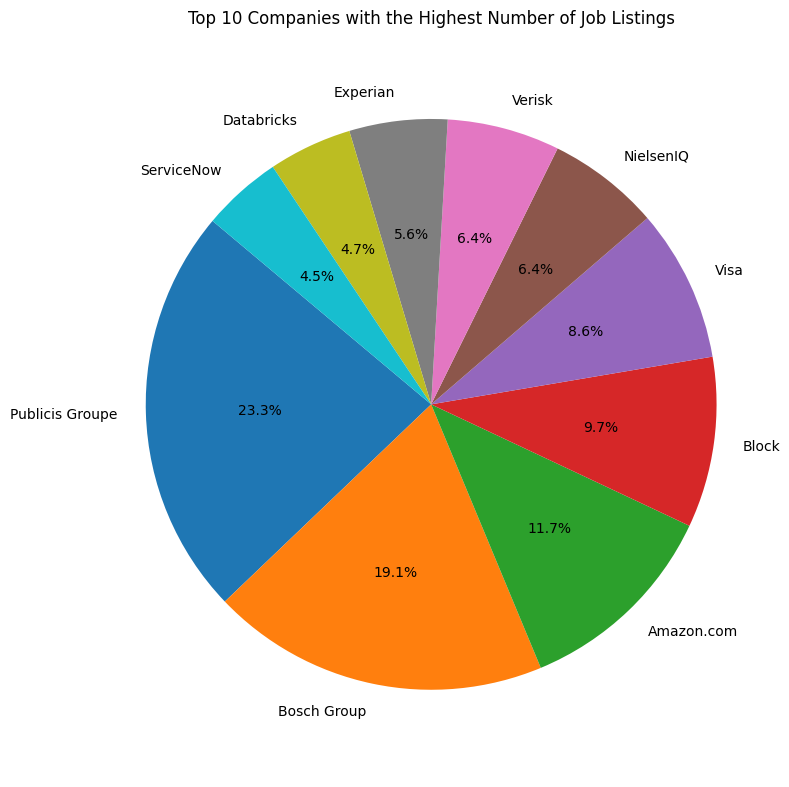

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
company_counts = df['Company'].value_counts().reset_index()
company_counts.columns = ['Company', 'Number of Job Listings']
top_10_companies = company_counts.head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_10_companies['Number of Job Listings'], labels=top_10_companies['Company'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Top 10 Companies with the Highest Number of Job Listings')
plt.tight_layout()
plt.show()


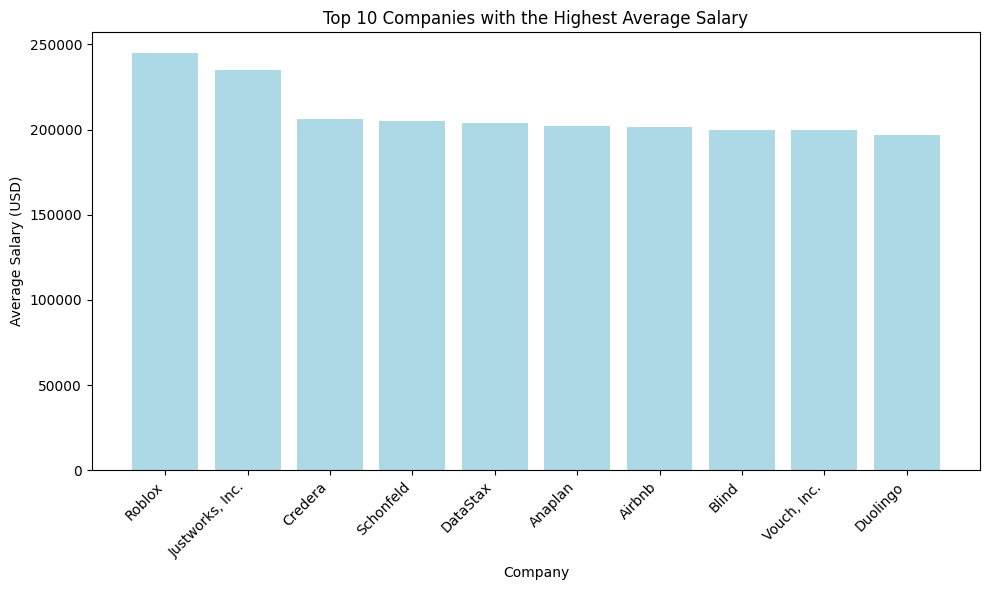

In [51]:
company_avg_salary = df.groupby('Company')['Salary'].mean().reset_index()
company_avg_salary = company_avg_salary.nlargest(10, 'Salary')

# Create a bar chart using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(company_avg_salary['Company'], company_avg_salary['Salary'], color='lightblue')
plt.xlabel('Company')
plt.ylabel('Average Salary (USD)')
plt.title('Top 10 Companies with the Highest Average Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pyodbc

connection_string = 'DRIVER={SQL Server};SERVER=LAPTOP-5VUQJT8J\SQLEXPRESS;DATABASE=Job;Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

countries = df[['Country']].drop_duplicates()
for _, country in countries.iterrows():
    cursor.execute(f"INSERT INTO Country (CountryName) VALUES ('{country['Country']}')")

domains = df[['Job Domain']].drop_duplicates()
for _, domain in domains.iterrows():
    cursor.execute(f"INSERT INTO DomainJob (DomainName) VALUES ('{domain['Job Domain']}')")

levels = df[['Experience level']].drop_duplicates()
for _, level in levels.iterrows():
    cursor.execute(f"INSERT INTO ExperienceLevel (LevelName) VALUES ('{level['Experience level']}')")

job_types = df[['Job Type']].drop_duplicates()
for _, job_type in job_types.iterrows():
    cursor.execute(f"INSERT INTO JobType (TypeName) VALUES ('{job_type['Job Type']}')")
conn.commit()
conn.close()


In [ ]:

connection_string = 'DRIVER={SQL Server};SERVER=LAPTOP-5VUQJT8J\SQLEXPRESS;DATABASE=Job;Trusted_Connection=yes;'

try:
    conn = pyodbc.connect(connection_string)
    cursor = conn.cursor()

    for _, row in df.iterrows():
        country_id_query = f"(SELECT TOP 1 Id FROM Country WHERE CountryName = ?)"
        domain_id_query = f"(SELECT TOP 1 Id FROM DomainJob WHERE DomainName = ?)"
        level_id_query = f"(SELECT TOP 1 Id FROM ExperienceLevel WHERE LevelName = ?)"
        type_id_query = f"(SELECT TOP 1 Id FROM JobType WHERE TypeName = ?)"

        cursor.execute(f"""
            INSERT INTO [dbo].[Offer_Job]
                   ([CompanyName]
                   ,[JobTitle]
                   ,[Location]
                   ,[Salary]
                   ,[RequirmentOfTheCompany]
                   ,[Facilities]
                   ,[CountryId]
                   ,[JobDomainId]
                   ,[ExperienceLevelId]
                   ,[JobTypeId])
             VALUES
                   (?, ?, ?, ?, ?, ?, ({country_id_query}), ({domain_id_query}),
                   ({level_id_query}), ({type_id_query}))
        """, row['Company'], row['Job Title'], row['Location'], row['Salary'],
           row['RequirmentOfTheCompany'], row['Facilities'], row['Country'],
           row['Job Domain'], row['Experience level'], row['Job Type'])
    conn.commit()

except Exception as e:
    print("An error occurred:", e)

finally:
    conn.close()
